<img align = 'center' src="./Images/ML_SWE.jpg" alt = 'image' width = '1000'/>


# Model Training


This notebook exemplifies the Sierra Snow Model (SSM) (a derivation of the National Snow Model (NSM)) data processing (through the DataProcess.py script), and model training, predictions, and preliminary evaluation via the MLP_model.py script.
With the focus of GeoSMART Hack Week to advance machine learning modeling skill sets, the motivation of the SSM project is for participants to modify the MLP_model.py script.
Suggested modifications include optimizing the current multilayered-perceptron (MLP) neural network algorithm or selecting and optimizing a different ML algorithm (strongly encouraged).
We encourage advanced modelers to contact Dr. Ryan Johnson (rjohnson18@ua.edu) for ideas and methods to optimize the model framework, there are several concepts of interest including feature engineering, domain optimization, feature selection, etc.

The following workflow exemplifies the steps and python files to process the training data, train a model, produce predictions, and perform preliminary evaluations

In [1]:
import DataProcess
import MLP_Model

2023-11-08 13:27:42.021979: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-08 13:27:42.026672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-08 13:27:42.026695: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Model Training and Testing Schema

The motivation the project is to advance the SSM skill for extrapolating regional SWE dynamics from in-situ observations.
To develop and test the SSM, we will train the model on NASA Airborne Snow Observatory (ASO) and snow course observations spanning 2013-2018, and some of 2019.
Within this training dataset, model training will use a random 75-25\% train-test data split. 
The random sample function will be 1234 to ensure all participants models use the same training and testing data for this phase of model development - note, this will support an intermodel comparision.

Model validation will be on water year 2019 and use the [NWM_MLP_2019_Simulation]('./NWM_MLP_2019_Simulation.ipynb').
This historical simulation will function as a hindcast, and use the 2019 water year NASA ASO and snow course observations to determine model performance. 


Upon the completion of model training, model execution predicts 1-km resolution SWE from data up to the current date of observation provided Latitude, Longitude, corresponding topographic data, and neighboring observation input features. From the sampling of test features, Chapter [Evaluation]('./evaluation.ipynb') compares the modeled 1-km grid SWE values to the observed values.

In [2]:
#Define hold out year
HOY = 2019
modelname = "Neural_Network"
Region_list = ['N_Sierras'] #, 'S_Sierras_Low', 'S_Sierras_High']
#Run data processing script to partition key regional dataframes
#note, need to load RegionTrain_SCA.h5,
RegionTrain, RegionTest, RegionObs_Train, RegionObs_Test, RegionTest_notScaled = DataProcess.DataProcess(HOY, modelname, Region_list)

Processing training dataframes for each region
N_Sierras


## Multilayered Precepton Network (MLP)
Given the identified optimal feature sets using recursive feature elimination (RFE), this step trains your model.
Here, the model is an ANN multilayer perceptron (MLP) regression model to estimate SWE found in the [MLP_Model]('./MLP_Model.py') file.
This file serves as a template for Hackweek participants to modify and by following the template, participants will be able to streamline model development and evaluation.

<img align = 'left' src="./Images/MLP_architecture.png" alt = 'image' width = '450'/>

The MLP is a classical type of feedforward ANN, successfully and frequently applied in environmental modeling applications.
The MLP regression model estimates a target variable by learning a non-linear function to describe the target from an input vector of features.
It performs learning via a back-propagation algorithm over a series of hidden layers containing interconnected nodes (neurons). 
The neurons connect bordering layers by a summation of weights and an activation function transforms model outputs to predicted values (i.e., SWE (in)). 
The model calculates error and adjusts the weights to minimize the error during model training, supporting the use of 
MLPs to effectively describe a target variable with any function, continuous or discontinuous. 

Model training leveraged the Keras API within the TensorFlow library.
We selected the popular, open-source TensorFlow and Keras platforms for their wide applicability and capabilities in deep learning.
The MLP model for the region consists of an input layer containing nodes for each feature in the optimized feature space, 7 dense hidden layers, and an output layer of the target SWE value. 
Model formulation uses the Rectified Linear Unit (ReLu) activation function to transform each hidden layer to non-linearize the solution.

In [3]:
#model training, each participants model will be different but should follow the prescribed input feature template
epochs= 60
MLP_Model.Model_train(epochs, RegionTrain, RegionTest, RegionObs_Train, RegionObs_Test, Region_list)

Training model for:  N_Sierras
All previous files deleted successfully.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 105)]             0         
                                                                 
 dense (Dense)               (None, 128)               13568     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                       

2023-11-08 13:27:47.041197: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-11-08 13:27:47.041245: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-08 13:27:47.041271: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-whitelightning450): /proc/driver/nvidia/version does not exist
2023-11-08 13:27:47.041544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Make predictions on the random sample of testing data
<img align = 'center' src="./Images/predictivemodeling.jpg" alt = 'image' width = '600'/>

The next phase of model development is to examine model performance on the random sample of testing data.
Refining model predictions at this phase will ensure the best model performance for the Hold-Out-Year validation set.

In [5]:
#Need to create Predictions folder if running for the first time
Predictions = MLP_Model.Model_predict(RegionTest, RegionObs_Test, RegionTest_notScaled, Region_list)

8/8 [==============================] - 0s 2ms/step


## Perform Preliminary Model Evaluation

How does your model performance? 
We are using simple model evaluation metrics of R2 and RMSE to guage model performance.
You will perform a more exhaustive model evaluation in the [Evaluation]('./evaluation.ipynb') chapter.

Preliminary Model Analysis for:  N_Sierras
 R2 is  0.921260440676754
 RMSE is  10.221754973505998
 R2 fSCA is  0.9060452087502849
 RMSE fSCA is  11.165763946924997


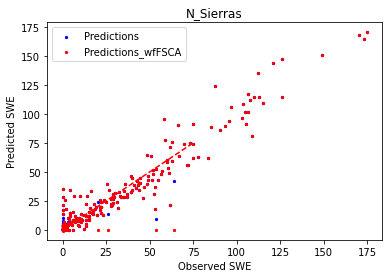

,Region,R2,RMSE,R2_fSCA,RMSE_fSCA
0,N_Sierras,0.92,10.22,0.91,11.17


In [6]:
Performance = MLP_Model.Prelim_Eval(Predictions)
Performance

### Model Evaluation

Now that we have a trained model producing acceptable performance, it is time to more rigorously evaluate its performance using the [Standardized Snow Water Equivalent Tool](./SSWEET.py) within an interactive [evaluation notebook](./evaluation.ipynb).

In [2]:
#save model weights and key criteria to AWS S3
modelname = 'Neural_Network'
Region = 'N_Sierras'
MLP_Model.save_model_AWS(modelname, Region)

Pushing files to AWS


100% |########################################################################|
